In [1]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs
sns.set_style('white')

workspace_dir  = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir        = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v2'

dpi = 300

# Get QSM QC dataframes 

In [2]:
def get_df(popname):
    df = pd.read_csv(os.path.join(pheno_dir, 'df_%s_qc.csv'%popname),index_col = 0)
    return df 

controls = get_df('controls')
patients = get_df('patients')

# Subjects beyond normal serum ferritin range and 3SDs
drop_c = ['RJJT'] 
drop_p = ['SA5U'] 

#concatenate dataframes
df_all = pd.concat([controls, patients], axis =0).drop(drop_p + drop_c, axis = 0)

/Users/kanaaax/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


# Define fitting forumula and plotting functions

In [3]:
def sortdf(df,m):
    return df.sort(m)[m]
 
def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = 0, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, ci = 95, lstyle='-',lw=2.5, label = None, printp=False):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter, 
                    ci = ci, line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 7)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    
    if label:
        plt.ylabel(y)
        plt.xlabel(x)
    else:
        grid.set_axis_labels()
        
    if annotate == 1:
        annotate = (plt.xlim()[1]*0.6,  plt.ylim()[1]*0.95)
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    elif annotate == 0:
        pass
    else:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    
    
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    
    if printp:
        print pcor, p_val
    return result

def plot_joint(df,m1,m2, drop = []):
    DF  = pd.DataFrame([df[m1] , df[m2]] ).T.dropna()
    sns.jointplot(x=m1, y=m2, data=DF.drop(drop, axis = 0), kind = 'reg')

# Visualize relationship between serum ferritin and striatal susceptibility 

/Users/kanaaax/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


0.543 0.0204883


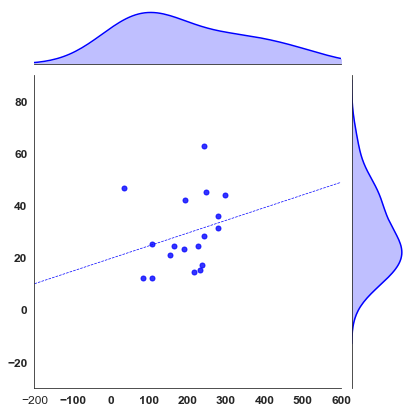

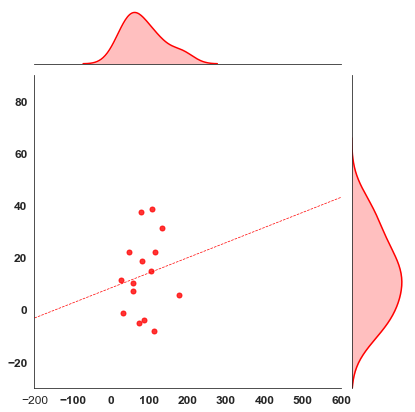

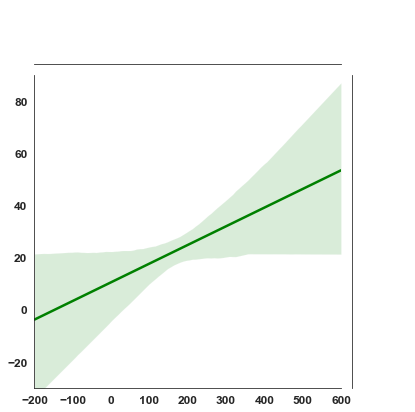

In [4]:
drop_p = ['SA5U']
drop_c = ['RJJT']
df_all = pd.concat([controls, patients], axis =0).drop(drop_p + drop_c, axis = 0)

x = 'CLN_Ferritin'
y = 'BG'
regressorsx = ['Age', 'Gender', 'QI1_MAG', 'EFC_MAG']
xlim  = (-200, 600)
ylim  = (-30,90)

plot_partial_correlation(controls, x, y, regressors = regressorsx, color = 'b', ci = None,
                         labels = False, lstyle='--', lw=0.7, #annotate = (250,80),
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         #fig_name = 'corr_chi_fer_controls.png'
                        )

plot_partial_correlation(patients.drop(drop_p,axis=0), x, y, regressors = regressorsx, color = 'r', ci = None,
                         labels = False, lstyle='--', lw=0.7, #annotate = (250,70),
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         #fig_name = 'corr_chi_ferr_patients.png'
                        )

plot_partial_correlation(df_all, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, printp=1, #annotate = (250,60),
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         #fig_name = 'corr_chi_ferr_all.png'
                        )


# Extract QSM and Ferritin data for indepdent sample from 
# https://www.nature.com/articles/sdata2018308


In [5]:
lemon = pd.read_csv(os.path.join(pheno_dir, 'df_raw_lemon.csv'), index_col=0)
lemon_cln =pd.read_csv(os.path.join(pheno_dir, 'df_lemon_ferritin.csv'),index_col=0)
lemon_cln.index = [i.upper() for i in lemon_cln.index]
lemon['ferritin'] = lemon_cln.Ergebnis

x = 'ferritin'
y = 'Caud_Puta'

lemon = lemon.drop([i for i in lemon.columns if i not in regressorsx + [x,y]], axis=1).dropna()


0.511 1e-07


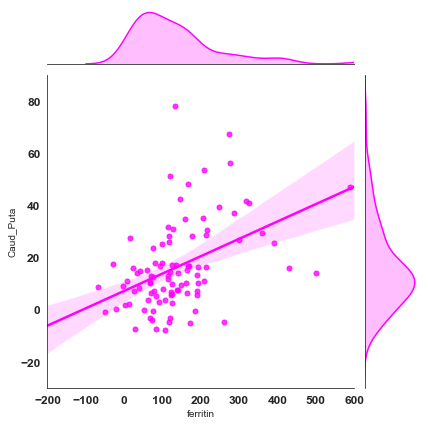

In [8]:
nstd = 2
#drop_ferr  = detect_outlier_subjects(lemon,'ferritin',m=nstd)
#drop_chi   = detect_outlier_subjects(lemon,y,m=nstd)
drop_chibg = [i for i in lemon.index if lemon.loc[i][y] < -10.]
drop_ferrx = [i for i in lemon.index if lemon.loc[i]['ferritin'] > 400.]

outliers = np.unique(#drop_chi
#                     +drop_ferr
                     drop_chibg
                    )

df = lemon.drop(outliers)

regressorsz = ["Gender",'QI1_MAG', 'EFC_MAG']
#xlim  = None#(-100, 600)
#ylim  = None#(-20,70)

plot_partial_correlation(df, x, y, regressors = regressorsz, color = 'magenta', 
                         labels = False, printp=1, #annotate = (200,30),
                         fit_reg=True, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, label = 1,
                        )

In [7]:
len(lemon)

100